# 1) Data preparation

In this notebook, we will download the datasets, inspect a few images, and upload the datasets to S3.

In [2]:
from tqdm import tqdm
import sagemaker
from sagemaker import get_execution_role
from PIL import Image
import numpy as np

In [3]:
session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

prefix = "capstone-inventory-project"

Default Bucket: sagemaker-us-east-1-646714458109
AWS Region: us-east-1
RoleArn: arn:aws:iam::646714458109:role/service-role/AmazonSageMaker-ExecutionRole-20211122T183493


The cell below creates a folder called `data`, downloads training_validation_test data and arranges it into different folders. Inside each folder, subfolders contain images where the number of objects is equal to the name of the subfolder. For instance, all images in folder `1` has images with 1 object in them.

In [4]:
number_of_images = {
    "1": 1228,
    "2": 2299,
    "3": 2666,
    "4": 2373,
    "5": 1875
}

train_size = 0.7
validation_size = 0.2
test_size = 0.1

In [5]:
import os
import json
import boto3
 
def download_and_arrange_data(dataset):     
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items(): 
        # Which images for the dataset?
        if dataset == "train":
            start = 0
            end = int(number_of_images[k] * train_size)
        elif dataset == "validation":
            start = int(number_of_images[k] * train_size)
            end = start + int(number_of_images[k] * validation_size)
        elif dataset == "test":
            start = int(number_of_images[k] * (train_size+validation_size))
            end = number_of_images[k]
        else:
            print("Dataset not recognized!")
            return
            
        print(f"Downloading Images with {k} objects")
        directory=os.path.join("data", dataset, k)
        if not os.path.exists(directory):
            os.makedirs(directory)   
        
        count = 0
        for file_path in tqdm(v):
            if count <= end and count >= start:
                file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
                s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name), os.path.join(directory, file_name))
            count += 1

In [6]:
download_and_arrange_data("train")

  0%|          | 1/1228 [00:00<03:13,  6.33it/s]

  0%|          | 1/2299 [00:00<05:53,  6.50it/s]

  0%|          | 1/2666 [00:00<04:44,  9.36it/s]

  0%|          | 2/2373 [00:00<03:32, 11.13it/s]

  0%|          | 1/1875 [00:00<04:34,  6.82it/s]

100%|██████████| 1875/1875 [02:29<00:00, 12.58it/s]


In [7]:
download_and_arrange_data("validation")

 70%|███████   | 860/1228 [00:00<00:00, 5542.69it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]

 70%|███████   | 1867/2666 [00:00<00:00, 15234.77it/s]

 70%|███████   | 1663/2373 [00:00<00:00, 9367.45it/s]

 70%|███████   | 1313/1875 [00:00<00:00, 11573.42it/s]

100%|██████████| 1875/1875 [00:40<00:00, 45.94it/s]   


In [ ]:
download_and_arrange_data("test")

 90%|█████████ | 1106/1228 [00:00<00:00, 7394.74it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]

 90%|█████████ | 2400/2666 [00:00<00:00, 16470.56it/s]

 90%|█████████ | 2136/2373 [00:00<00:00, 20490.86it/s]

Let's explore our data a little.  
As we can see in the following cell, the data ordering/labelling seems correct.

Bin with 1 object(s)


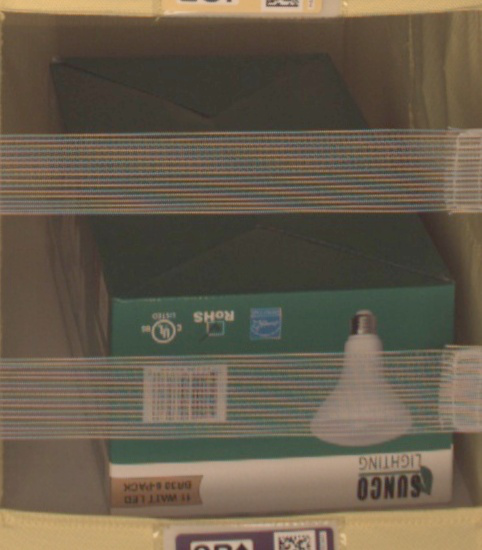

Bin with 2 object(s)


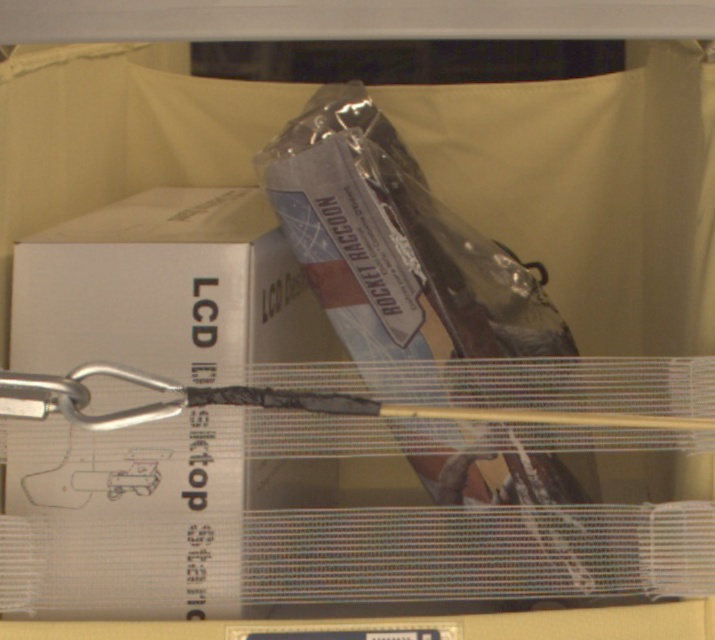

Bin with 3 object(s)


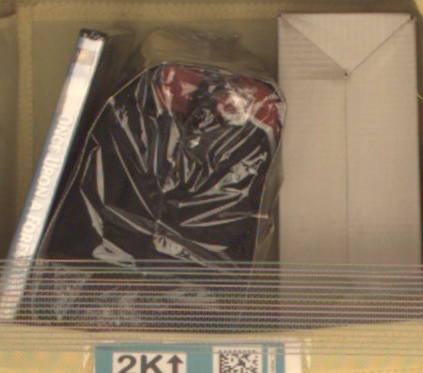

Bin with 4 object(s)


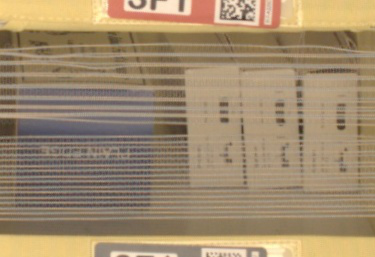

Bin with 5 object(s)


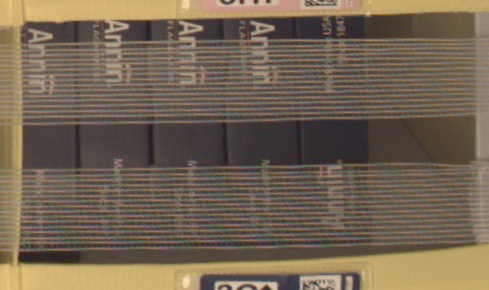

In [17]:
listOfImageNames = ['data/train/1/00024.jpg',
                    'data/train/2/00054.jpg',
                    'data/train/3/00158.jpg',
                    'data/train/4/00336.jpg',
                    'data/train/5/00238.jpg']

for imageName in listOfImageNames:
    print("Bin with {} object(s)".format(imageName[11]))
    display(Image.open(imageName))

However, when exploring the images a bit more thoroughly, a few problems/limitations can already be noticed.  
For example, the following image has been labelled as containing "1" object, which is clearly false.

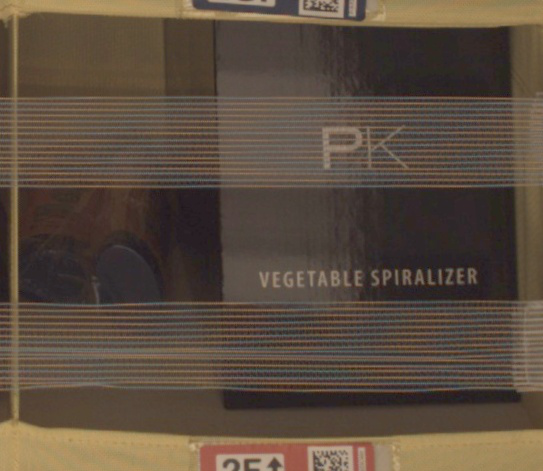

In [18]:
image1 = Image.open('data/train/1/00084.jpg')
display(image1)

It is hard to tell if it is due to a human labelling error, or if the objects are considered as one because of some promotional event.  
Similliarly, here are two images labelled as containing "2" objects.

Bin with 2 object(s)


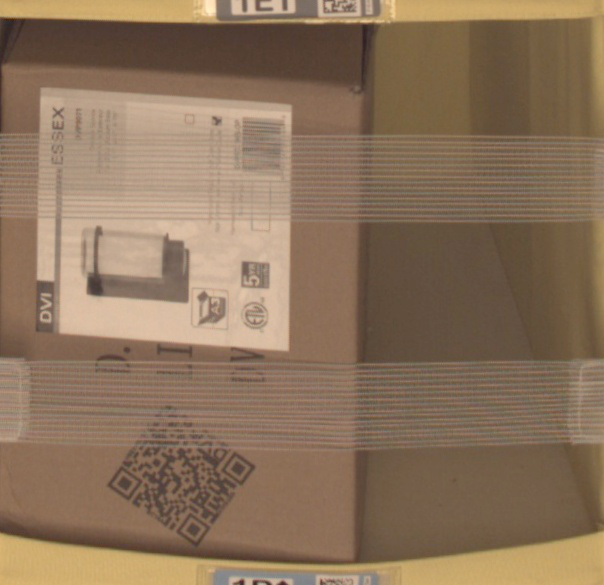

Bin with 2 object(s)


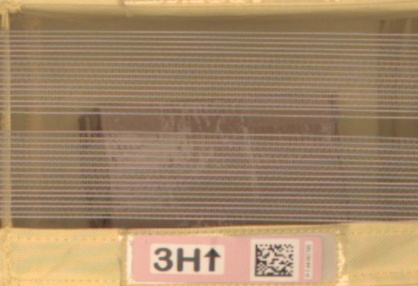

In [21]:
listOfImageNames = ['data/train/2/00473.jpg',
                    'data/train/2/00607.jpg'
                    ]

for imageName in listOfImageNames:
    print("Bin with {} object(s)".format(imageName[11]))
    display(Image.open(imageName))

As we can see, those bins seems to contain only 1 object.  
I see two possible explanations:
- The second object is hidden by the one in front.
- Human labelling error.

Etheir way, it will be extremely difficult (if not impossible) for any vision model to learn valuable insights from those pictures. 

Simillarly I find that images with 5 objects are extremely difficult to label. The objetcs tend to be squizzed and end up hiding each other.  
Because of the bin size and the way the pictures are taken, much important information is lost.  
Those limitations already hint the difficulties to create highly accurate model for this application.

Finally, let's export our dataset to S3.

In [11]:
%%capture
os.environ["PREFIX"] = prefix
os.environ["DATA"] = "data"
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync data s3://${DEFAULT_S3_BUCKET}/${PREFIX}/${DATA}/